# Making Color Color Diagrams

## What are X-ray colors?

In X-ray astronomy, we often use the term _color_ to mean the _hardness ratio_, $\mathbb{H}$.

$$
\mathbb{H} = \frac{H-S}{H+S}
$$

where $H$ and $S$ are the counts in two independent energy bands (Hard and Soft).  This ratio is restricted to the range $[-1,1]$. Values less than 0 indicate a _soft_ source, values greater than 0 indicate a _hard_ source.  

Propagating the errors on the above equation we get

$$
\sigma_{\mathbb{H}} = \frac{2\sqrt{(H\sigma_S)^2 + (S\sigma_H)^2}}{(H+S)^2}
$$

where $\sigma_S$ and $\sigma_H$ are the errors on $S$ and $H$ respectively and are usually estimated using Gehrels' approximation

$$
\sigma_X \approx 1+\sqrt{X+0.75}
$$

There is of course much in the literature about how best to compute this quantity and especially the error bars using Bayesian techniques. 

One common use of hardness ratios is when there are too few counts to obtain a statistically meaningful spectral fit.  Users can construct a _Color-Color_ diagram 



## What is a color-color diagram?

A color-color diagrams starts with an assumed spectral model, for example an absorbed power-law.  The color-color diagram is constructed by varying two of the independent model parameters, for example the slope of the power-law model component and the neutral Hydrogen density in the absorption model component.  The parameter values are varied over a few discrete values.  By including the instrument response, we can then simulate the observed spectra.  We compute the total number of simulated counts in 3 independent energy bands: soft, medium, hard; and then use those counts to construct a pair hardness ratios:  hard-to-medium and medium to soft.

$$
\mathbb{HM} = \frac{H-M}{H+M} \;\;\;\;\;\;\;
\mathbb{MS} = \frac{M-S}{M+S}
$$




The color-color diagram then is constructed by plotting the $\mathbb{HM}$ and $\mathbb{MS}$ values and connecting the points that represent fixed values for each of the two model parameters.

![Example Color Color diagram](color_color.png)

> Example color-color diagram using the Chandra ACIS 09 PIMMS arf, folded through an absorbed power-law : xswabs*xspowerlaw.  The powerlaw photon index was varied using the grid [1, 2, 3,4], the nH was varied using the grid [0.01, 0.1, 0.2, 0.5, 1.0, 10.0].  The soft energy band goes from 0.5 to 1.2 keV, the medium energy band goes from 1.2 to 2.0 keV and the hard energy band goes from 2.0 to 7.0 keV.

Users can then compute the hardness ratios for the sources in their observations and use the color-color plot to look-up what spectral model parameters yield the colors they computed. 


## This module

We provide here a set of routines to use _sherpa_ to compute the hardness ratios of arbitrary spectral models using the use supplied instrument response (ie the ARF file).

The plots are created with _matplotlib_ and can be manipulated and further annotated using it.


### Example

In [1]:
%matplotlib inline

In [2]:
import sherpa.astro.ui as ui
import matplotlib.pylab as plt

Load the routines/classes in this module

In [3]:
from color_color import *

Now we define our energy bands.  We will use the standard CSC soft, medium, and hard
energy limits.  

In [4]:
soft = EnergyBand( 0.5, 1.2, 'S')
medium = EnergyBand(1.2, 2.0, 'M')
hard = EnergyBand(2.0, 7.0, 'H')

Now we need to define our spectral model.  As before we are going to use an absorbed power law.
We will be using the Chandra cycle 9 proposal planning ARF to simulate the instrument response.


In [5]:
mymodel = ui.xswabs.abs1 * ui.xspowerlaw.pwrlaw
arffile = "acissD2006-10-26pimmsN0009.fits"

ao09 = ColorColor( mymodel, arffile )

The spectral model used for the color-color diagram is now set.  Note:  We did not use an RMF (response matrix) so we are using a diagonal response.  This is OK when the energy bands are wide compared to the spectral resolution; otherwise users can supply an RMF file to the ColorColor class constructor.

Now we define grid we want to use to compute the color-color diagram.

To improve the quality of the plots, the actual lines are computed by oversampling the use supplied grid.  
So in this example, the power law photon index will be varied on the grid $[1,2,3,4]$; but when drawing the lines, 
the grid will be oversampled to have $20$ data points between $1$ and $2$, $20$ data points between $2$ and $3$, and so on.

In [6]:
pho_grid = [ 1., 2., 3., 4. ]
photon_index = ModelParameter( pwrlaw.PhoIndex, pho_grid, fine_grid_resolution=20)

For the second axis, we will vary the nH in the absorption model.  

Since nH varies differently, we pick a quasi-logarithmic scale for our user supplied  grid. In this case we need to be sure we get the units correct.  

In [7]:
sg = [ 1.e20, 1.e21, 2.e21, 5.e21, 1.e22, 1e23] 
nh_grid = [x/1e22 for x in sg ]
absorption = ModelParameter( abs1.nH, nh_grid, fine_grid_resolution=20)

We are now ready to compute the hardness ratios for our spectral model using our selected energy bands.

In [8]:
matrix_09 = ao09( photon_index, absorption, soft, medium, hard)

We can then call the `plot()` method to get the color-color diagram

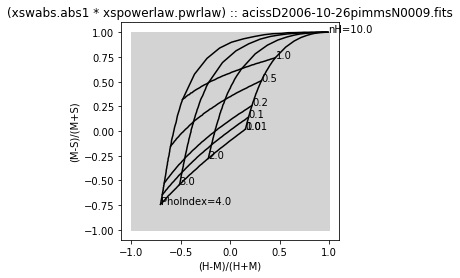

In [9]:
matrix_09.plot()

We can tweak the color and line-style using the `set_curve_style` and `set_label_style` for the parameter axes

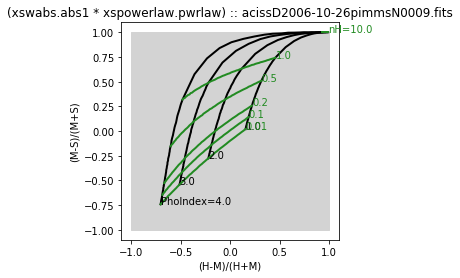

In [10]:
photon_index.set_curve_style(marker="", linestyle="-", linewidth=2, color="black")
photon_index.set_label_style(color="black")
absorption.set_curve_style(marker="", linestyle="-", linewidth=2, color="forestgreen")
absorption.set_label_style(color="forestgreen")

matrix_09.plot()

and we can further annotate the plots, eg by including the HR the source we observed

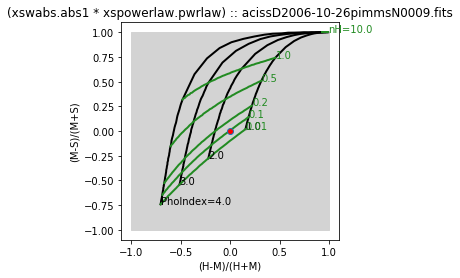

In [11]:
matrix_09.plot()

plt.plot([0],[0],marker="o",mfc="red")
plt.show()

Users can also save the values using the `.write()` method

In [12]:
matrix_09.write("hr.fits")

In [13]:
!dmlist hr.fits cols

 
--------------------------------------------------------------------------------
Columns for Table Block TABLE
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   PhoIndex                          Real8          -Inf:+Inf            
   2   nH                                Real8          -Inf:+Inf            
   3   HM                                Real8          -Inf:+Inf            
   4   MS                                Real8          -Inf:+Inf            


Note: There will be duplicate rows in the file with the same `PhoIndex` and `nH` with possibly different `HM` and `MS` 
values (remember, these values are obtained from a simulated, ie `fake()` spectrum and subject to randomization).